# Tensorboard로 모델, 데이터, 학습 시각화하기

진행 상황을 확인하기 위해, 학습이 진행 중일 때 학습이 잘 되고 있는지를 알아보기 위해 몇몇 수치들을 출력해야 한다. 

PyTorch는 학습 내역을 시각화하는 도구인 TensorBoard와 통합되어있다.

이 튜토리얼에서는 PyTorch의 torchvision.datasets에서 사용 가능한 Fashion-MNIST dataset으로 일부 기능을 설명한다.

# 개요

1. 데이터를 읽고 적절히 변환한다.
2. TensorBoard를 set up
3. TensorBoard에 write
4. TensorBoard를 사용하여 모델 구조를 살펴본다.
5. 코드를 추가하여 TensorBoard에서 이전 튜토리얼에서 만든 시각화의 interactive 버전을 만든다.
   1. 학습 데이터를 검사(inspect)하는 몇 가지 방법
   2. 학습에 따른 모델의 성능을 추적(track)하는 방법
   3. 학습이 완료된 모델의 성능을 평가(assess)하는 방법

In [2]:
# imports

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
# transforms

transform = transforms.Compose(
    [transforms.ToTensor(), # 0~1의 범위를 가지도록 정규화가 된다.
    transforms.Normalize((0.5,), (0.5,))
    # transforms.Normalize((r채널, g채널, b채널), (r채널 표준편차, g채널 표편, b채널 표편))
    ]
)

In [6]:
# datasets

trainset = torchvision.datasets.FashionMNIST('/Users/junghwankim/Desktop/pytorch_tutorial/data',
    download= True,
    train= True,
    transform=transform)

testset = torchvision.datasets.FashionMNIST('/Users/junghwankim/Desktop/pytorch_tutorial/data',
    download=True,
    train=False,
    transform=transform)

In [7]:
# dataloaders

from random import shuffle


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
# classification 결과를 위한 상수
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [10]:
# image를 보여주기 위한 helper function
# (아래 'plot_classes_preds' 함수에서 사용함)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap = 'Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


이전 튜토리얼과 유사한 모델 구조를 정의하되, 이미지의 채널이 3개에서 1개로, 크기가 (32,32)에서 (28,28)로 변경된 것을 적용할 수 있도록 약간만 수정.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net = Net()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 1. TensorBoard 설정

이제 torch.utils의 tensorboard를 불러오고, TensorBoard에 정보를 제공(write)하는 SummaryWriter를 주요한 객체인 SummaryWriter를 정희하여 TensorBoard를 설정합니다.

In [16]:
from torch.utils.tensorboard import SummaryWriter

# 기본 'log_dir'은 'runs'이며, 여기서는 더 구체적으로 지정
writer = SummaryWriter('runs/fashion_mnist_experiment_1')
# 4번 줄을 통해서 runs/fashion_mnist_experiment_1 폴더를 생성

# 2. TensorBoard에 기록하기

이제 TensorBoard에 이미지(구체적으로는 make_grid를 사용하여 grid)를 써보겠습니다.

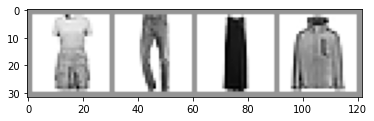

In [17]:
# 임의의 학습 이미지를 가져온다.
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 그리드를 만든다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여준다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록한다.
writer.add_image('four_fashion_mnist_images', img_grid)

In [44]:
# tensorboard 커맨드 실행 명령어
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# 3. TensorBoard를 사용하여 모델 살펴보기

Tensorboard의 강점 중 하나는 복잡한 모델 구조를 시각화하는 기능이다. 지금까지 만든 모델을 시각화해보자.

In [21]:
writer.add_graph(net, images)
writer.close()

텐서보드는 이미지 데이터와 같은 고차워 데이터를 저차원 공간에 시각화하는데 매우 편리한 기능들을 제공한다. 앞으로 이 내용을 알아보겠다.

# 4. TensorBoard에 'Projector' 추가하기

add_embedding method를 통해 고차원 데이터의 저차원 표현을 시각화할 수 있다.

In [23]:
# helper function

def select_n_random(data, labels, n = 100):
    '''
    데이터셋에서 n개의 임의의 데이터포인트와 그에 해당하는 라벨을 선택
    '''

    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

In [24]:
# 임의의 이미지들과 정답 인덱스를 선택
images, labels = select_n_random(trainset.data, trainset.targets)

In [25]:
# 각 이미지의 class label을 가져온다.

class_labels = [classes[lab] for lab in labels]

In [26]:
# embedding 내역을 기록

features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

# 5. TensorBoard로 모델 학습 추적하기

이전 예제에서는 단순히 모델 학습 중 running loss를 2000번 바복할 때마다 출력하기만 했다. 

이제는 tensorboard에 학습 중 손실을 기록하는 것 대신 plot_classes_preds 함수를 통해 모델의 예측 결과를 함께 볼 수 있게 하자.

In [28]:
# helper function

def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]
    


In [29]:
def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지/라벨을 사용하여 matplotlib Figure를 생성한다.
    이는 신경망의 예측 결과/확률과 함께 정답을 보여주며, 예측 결과가 맞았는지 여부에 따라 색을 다르게 표시한다.
    'images_to_probs'함수를 사용한다.
    '''
    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과/정답과 함께 표시 한다.
    fig = plt.figure(figsize=(12,48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2}".format(classes[preds[idx]], probs[idx]*100.0, classes[labels[idx]]), color=('green'if preds[idx]==labels[idx].item() else 'red'))
    return fig

마지막으로, 이전 튜토리얼과 동일한 모델 학습 코드에서 1000배치마다 콘솔에 출력하는 대신에 TensorBoard에 결과를 기록하도록 하여 학습을 해보자 : 이는 add_scalar 함수를 사용

또한 학습을 진행하며 배치에 포함된 4개의 이미지에 대한 모델의 예측 결과와 정답을 비교하여 보여주는 이미지를 생성하도록 하겠다.

In [30]:
running_loss = 0.0
for epoch in range(1): #데이터셋을 여러 번 반복
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력 받은 후
        inputs, labels = data
        # gradient 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999: #매 1000 배치마다
            # 학습 중 running loss를 기록
            writer.add_scalar('training loss', running_loss / 1000, epoch * len(trainloader) + i)
            # 무작위 미니배치에 대한 모델의 예측 결과를 보여주게 matplotlib figure를 기록
            writer.add_figure('predictions vs actuals', plot_classes_preds(net, inputs, labels), global_step=epoch * len(trainloader) + i)
            running_loss = 0.0

print('finish training')

finish training


# 6. TensorBoard로 학습된 모델 평가하기

In [40]:
# 1. 예측 확률을 test_size * num_classes 텐서로 가져온다.
# 2. 예측 결과를 test_size 텐서로 가져온다.
# 실행하는데 10초 이하 소요

class_probs = []
class_label = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch)for batch in class_probs])
test_label = torch.cat(class_label)

In [42]:
# helper function

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    ''' 
    0~9까지의 'class_index'를 가져온 후 해당 precision-recall 곡선을 그린다.
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index], tensorboard_truth, tensorboard_probs, global_step=global_step)
    writer.close()

In [43]:
# 모든 precision-recall 곡선을 그린다.
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)